<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Андрей Шапиро 

# <center>Прогнозирование дневных температур в городе Челябинске</center>
### <center> Индивидуальный проект по анализу данных</center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

In [29]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

###  Часть 1. Описание набора данных и признаков

Имется набор данных о погоде за восемь лет. Данные состоят из утренних и дневных замеров величин температуры, влажности, атмосферного давления, силы и направления ветра, а также состояния геомагнитного поля. Температура — целевой признак, который мы хотим прогнозировать.

In [30]:
df = pd.read_csv('chelpogoda.csv', sep=';',
                 dtype = {'datetime': str,
                           'temperature': np.int32,
                           'humidity': np.int32,
                           'pressure': np.int32,
                           'magnetic': str,
                           'wind': str
                })

In [31]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d, %H:%M', errors='coerce')
df['date'] = df['datetime'].map(lambda x: x.date())

In [32]:
df.head()

,datetime,temperature,humidity,pressure,magnetic,wind,date
0,2008-06-18 15:00:00,28,39,740,Геомагнитное поле спокойное,Ветер 3 м/с,2008-06-18
1,2008-06-19 09:00:00,19,63,741,Геомагнитное поле спокойное,Ветер юго-восточный 2 м/с,2008-06-19
2,2008-06-19 15:00:00,30,27,741,Геомагнитное поле спокойное,Ветер южный 2-5 м/с,2008-06-19
3,2008-06-20 09:00:00,21,50,740,Геомагнитное поле спокойное,Ветер южный - 1 м/с,2008-06-20
4,2008-06-20 15:00:00,32,31,740,Геомагнитное поле спокойное,Ветер юго-западный 3-7 м/с,2008-06-20


#### Магнитное поле
Данные о магнитном поле и ветре в текстовом виде и частично загрязнены ошибками ввода:

In [33]:
np.unique(df['magnetic'])[1:10]

array(['Геомагнитное поле : неустойчивое', 'Геомагнитное поле : спокойное',
       'Геомагнитное поле :спокойное', 'Геомагнитное поле ?????????',
       'Геомагнитное поле cпокойное', 'Геомагнитное поле Спокойное',
       'Геомагнитное поле возможно неустойчивое',
       'Геомагнитное поле возможно слабо возмущенное',
       'Геомагнитное поле возмущенное'], dtype=object)

Создадим из текстового описания магнитного поля три категориальных переменных, соответствующих спокойному, неустойчивому и возмущенному геомагнитное полю

In [34]:
df['magn_calm'] = df['magnetic'].str.match('.*[cс][по][рко].*').astype(int)
df['magn_unstable'] = df['magnetic'].str.match('.*не[уч]с?то.*').astype(int)
df['magn_disturbant'] = df['magnetic'].str.match('.*возмущ.*').astype(int)

#### Ветер

In [35]:
np.unique(df['wind'])[1:20]

array(['Ветер 2-6 м/с', 'Ветер 3 м/с', 'Ветер 80',
       'Ветер :Западный 2-6 м/с', 'Ветер :Западный 3-8 м/с',
       'Ветер ???????? 2-6 ?/?', 'Ветер cверный 2-5 м/с',
       'Ветер cеверный 1-3 м/с', 'Ветер cеверный 1-5 м/с',
       'Ветер cеверный 1-7 м/с', 'Ветер cеверный 2-11 м/с',
       'Ветер cеверный 2-5 м/с', 'Ветер cеверный 2-6 м/с',
       'Ветер cеверный 2-7 м/с', 'Ветер cеверный 2-8 м/с',
       'Ветер cеверный 3-10 м/с', 'Ветер cеверный 3-5 м/с',
       'Ветер cеверный 3-6 м/с', 'Ветер cеверный 3-7 м/с'], dtype=object)

Возьмём минимальное и максимальное значения скорости ветра в качестве двух признаков.

In [36]:
wind_minmax = df['wind'].str.extract('(\d+)-?(\d+)? ?.*', expand=False)
df['wind_min'] = wind_minmax.iloc[:, 0]
df['wind_max'] = wind_minmax.iloc[:, 1]

df['wind_max'] = list(map(lambda x: float(df.loc[x[0], 'wind_min']) if np.isnan(float(x[1])) else float(x[1]), enumerate(df['wind_max'].values)))
df['wind_min'] = df['wind_min'].astype(float)

###  Часть 2. Первичный анализ признаков

In [37]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
X = df[['datetime', 'humidity', 'pressure', 'magn_calm', 'magn_unstable', 'magn_disturbant']]
y = df[['temperature']]

X['wind_max'] = df['wind_max'].fillna(0).astype(int)

/Users/andrew/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
X.iloc[1:7,:]

,datetime,humidity,pressure,magn_calm,magn_unstable,magn_disturbant,wind_max
1,2008-06-19 09:00:00,63,741,1,0,0,2
2,2008-06-19 15:00:00,27,741,1,0,0,5
3,2008-06-20 09:00:00,50,740,1,0,0,1
4,2008-06-20 15:00:00,31,740,1,0,0,7
5,2008-06-21 09:00:00,72,740,1,0,0,3
6,2008-06-21 15:00:00,49,739,1,0,0,4


Корреляция вещественных признаков и целевой переменной:

In [39]:
corr_matrix = df[['temperature', 'humidity', 'pressure', 'magn_calm', 'magn_unstable', 'magn_disturbant']].corr(method='pearson')
corr_matrix

,temperature,humidity,pressure,magn_calm,magn_unstable,magn_disturbant
temperature,1.000000,-0.335995,-0.220140,0.008475,-0.000560,-0.013403
humidity,-0.335995,1.000000,-0.012302,0.007456,-0.014027,0.010870
pressure,-0.220140,-0.012302,1.000000,0.006086,-0.010453,0.004553
magn_calm,0.008475,0.007456,0.006086,1.000000,-0.896722,-0.351930
magn_unstable,-0.000560,-0.014027,-0.010453,-0.896722,1.000000,-0.076798
magn_disturbant,-0.013403,0.010870,0.004553,-0.351930,-0.076798,1.000000


###  Часть 3. Первичный визуальный анализ признаков

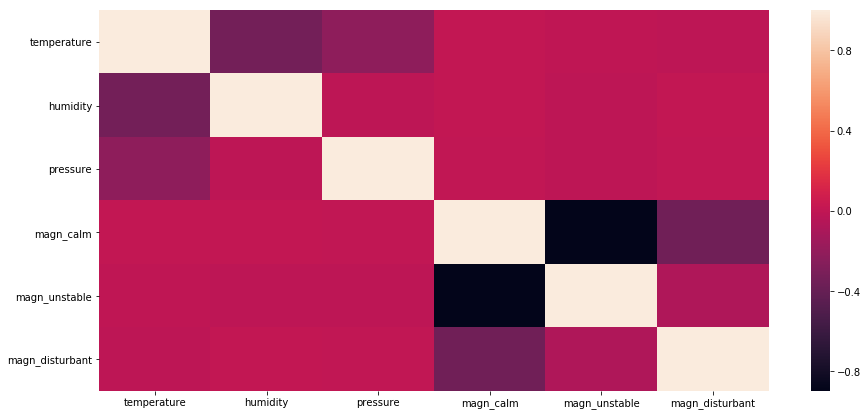

In [40]:
plt.figure(figsize=(15, 7))
sns.heatmap(corr_matrix);

In [41]:
df['magnetic_num'] = np.asarray(list(map(lambda x: 1*df['magn_calm'][x] \
                                + 2*df['magn_unstable'][x] \
                                + 3*df['magn_disturbant'][x], list(range(0, df.shape[0])))))

In [42]:
df['magnetic'] = df['magnetic'].map(dict({0: 'Unknown', 1: 'Calm', 2: 'Unstable', 3: 'Disturbant'}))

/Users/andrew/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


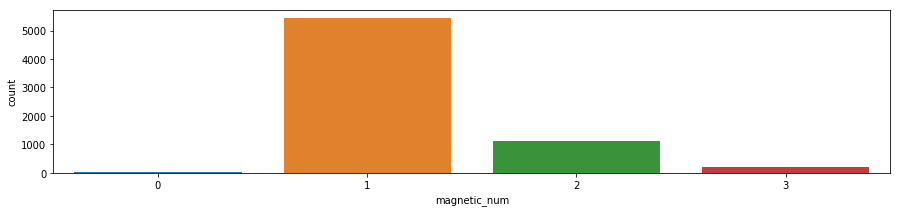

In [43]:
plt.figure(figsize=(15, 3));
sns.countplot(df['magnetic_num']);

In [44]:
# drop outliers
df['pressure'] = list(map(lambda x: x if x > np.percentile(df['pressure'], 0.05) \
                          else np.median(df['pressure']), df['pressure']))

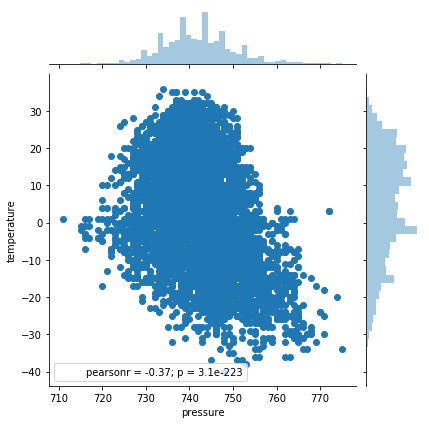

In [45]:
sns.jointplot(x = "pressure", y = "temperature", data = df);

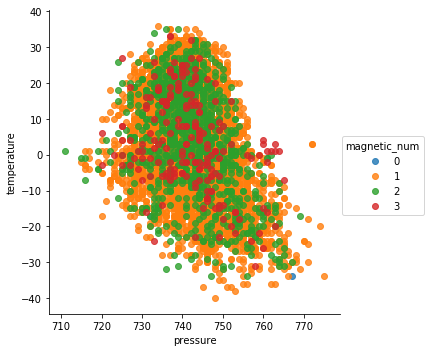

In [58]:
sns.lmplot(x='pressure', y='temperature', hue='magnetic_num', data=df, fit_reg=False);

In [47]:
# drop outliers
df['humidity'] = list(map(lambda x: x if x < np.percentile(df['humidity'], 99.9) \
                          else np.median(df['humidity']), df['humidity']))

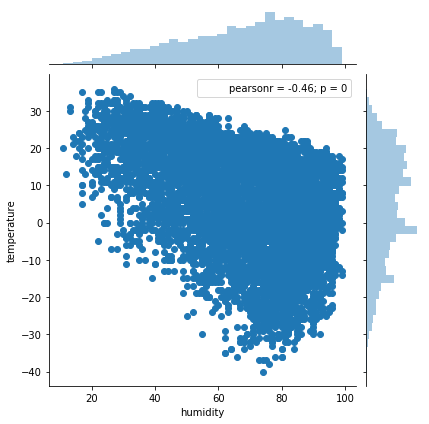

In [48]:
sns.jointplot(x = "humidity", y = "temperature", data = df);

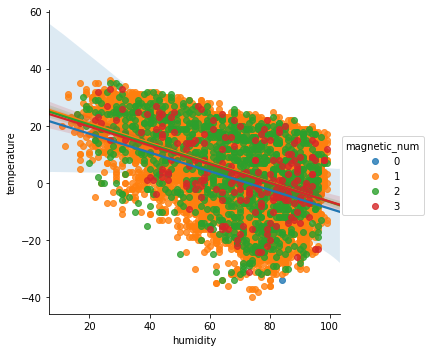

In [50]:
sns.lmplot(x='humidity', y='temperature', hue='magnetic_num', data=df);

In [51]:
# drop outliers
from numpy import nanmedian
df['wind_max'].fillna(np.nanmedian(df['wind_max']), inplace=True)

df['wind_max'] = list(map(lambda x: x if x < np.percentile(df['wind_max'], 99.9) \
                          else np.median(df['wind_max']), df['wind_max']))

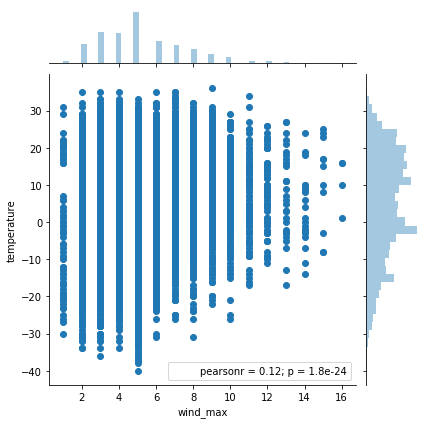

In [52]:
sns.jointplot(x = "wind_max", y = "temperature", data = df);

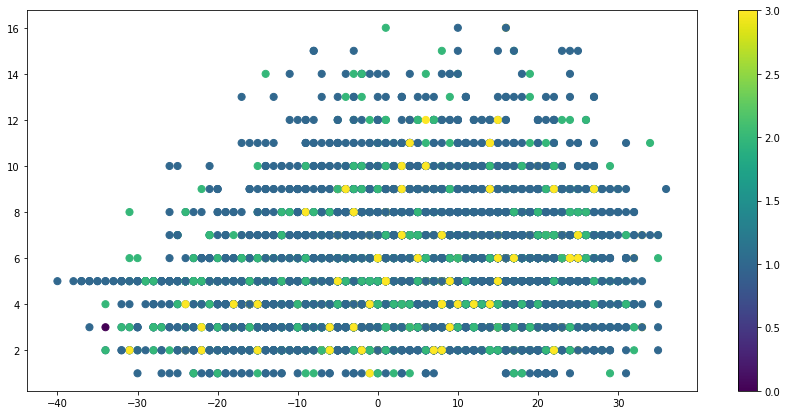

In [53]:
#sns.jointplot(x = "wind_max", y = "temperature", col = 'magnetic', data = df);
plt.figure(figsize=(15, 7))
plt.scatter(df["temperature"], df["wind_max"], c=df['magnetic_num'], s=50, cmap='viridis');
plt.colorbar();

In [57]:
plt.figure(figsize=(15, 7));
sns.violdinplot(x = 'date', y = 'temperature', hue = 'magnetic', scale = 'count', data = df);

AttributeError: module 'seaborn' has no attribute 'violdinplot'

###  Часть 4. Закономерности, "инсайты", особенности данных

###  Часть 5. Предобработка данных 

###  Часть 6. Создание новых признаков и описание этого процесса

###  Часть 7. Кросс-валидация, подбор параметров

###  Часть 8. Построение кривых валидации и обучения 

###  Часть 9. Прогноз для тестовой или отложенной выборки

###  Часть 10. Оценка модели с описанием выбранной метрики

### Часть 11. Выводы 